In [1]:
!pip install tensorflow

In [2]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128
IMG_CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 50
NUM_CLASSES = 1

# Paths
IMAGE_DIR = r'E:\BIOSE\Kvasir-SEG\images'
MASK_DIR = r'E:\BIOSE\Kvasir-SEG\masks'
# Load and preprocess data
def load_data(image_dir, mask_dir, img_height, img_width):
    images = []
    masks = []
    image_filenames = os.listdir(image_dir)
    for fname in image_filenames:
        img = load_img(os.path.join(image_dir, fname), target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0

        mask = load_img(os.path.join(mask_dir, fname), target_size=(img_height, img_width), color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        if NUM_CLASSES == 1:
            mask = (mask > 0.5).astype(np.float32)

        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

X, Y = load_data(IMAGE_DIR, MASK_DIR, IMG_HEIGHT, IMG_WIDTH)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# SegNet model
def build_segnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Output layer
    activation = "sigmoid" if num_classes == 1 else "softmax"
    outputs = Conv2D(num_classes, (1, 1), activation=activation)(x)

    model = Model(inputs, outputs)
    return model

# Build and compile
model = build_segnet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), NUM_CLASSES)
model.compile(optimizer=Adam(), loss="binary_crossentropy" if NUM_CLASSES == 1 else "categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Train
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# --------- Save CSV History ---------
history_dict = history.history
history_dict['Epoch'] = list(range(1, EPOCHS + 1))  # Add epoch numbers

df = pd.DataFrame(history_dict)
df = df[['Epoch'] + [col for col in df.columns if col != 'Epoch']]  # Ensure Epoch is the first column

df.to_csv("biose_segnet_org_dt.csv", index=False)
print("Training history saved as biose_segnet_org_dt.csv")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,333,377 (5.09 MB)

 Trainable params: 1,331,585 (5.08 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7437 - loss: 0.5459 - val_accuracy: 0.8368 - val_loss: 0.4957
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8542 - loss: 0.3289 - val_accuracy: 0.8368 - val_loss: 0.5674
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8517 - loss: 0.3258 - val_accuracy: 0.8369 - val_loss: 0.5037
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8669 - loss: 0.3017 - val_accuracy: 0.8375 - val_loss: 0.4491
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8670 - loss: 0.3054 - val_accuracy: 0.6061 - val_loss: 0.6663
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8765 - loss: 0.2856 - val_accuracy: 0.8414 - val_loss: 0.3586
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8717 - loss: 0.2929 - val_accuracy: 0.8510 - val_loss: 0.3467
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8855 - loss: 0.2677 - val_accu

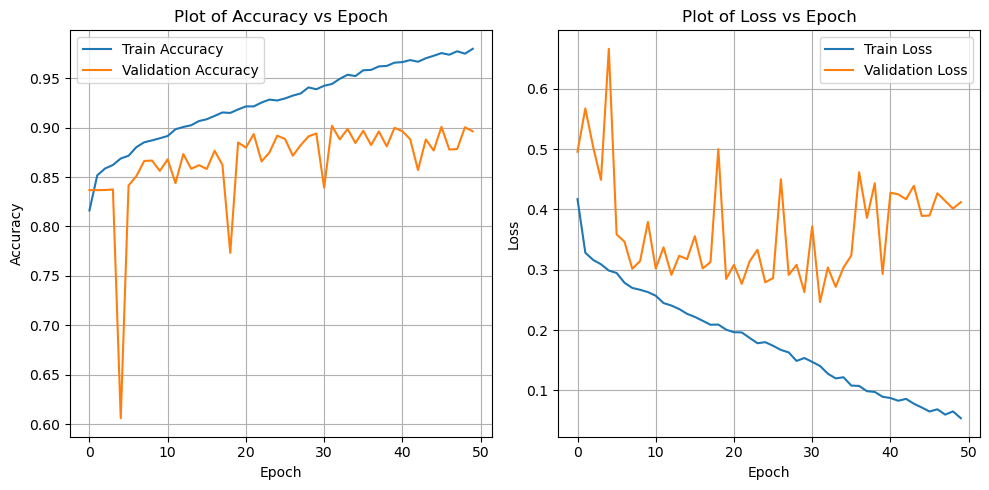

In [3]:
# Accuracy and Loss Graphs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Plot of Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Plot of Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


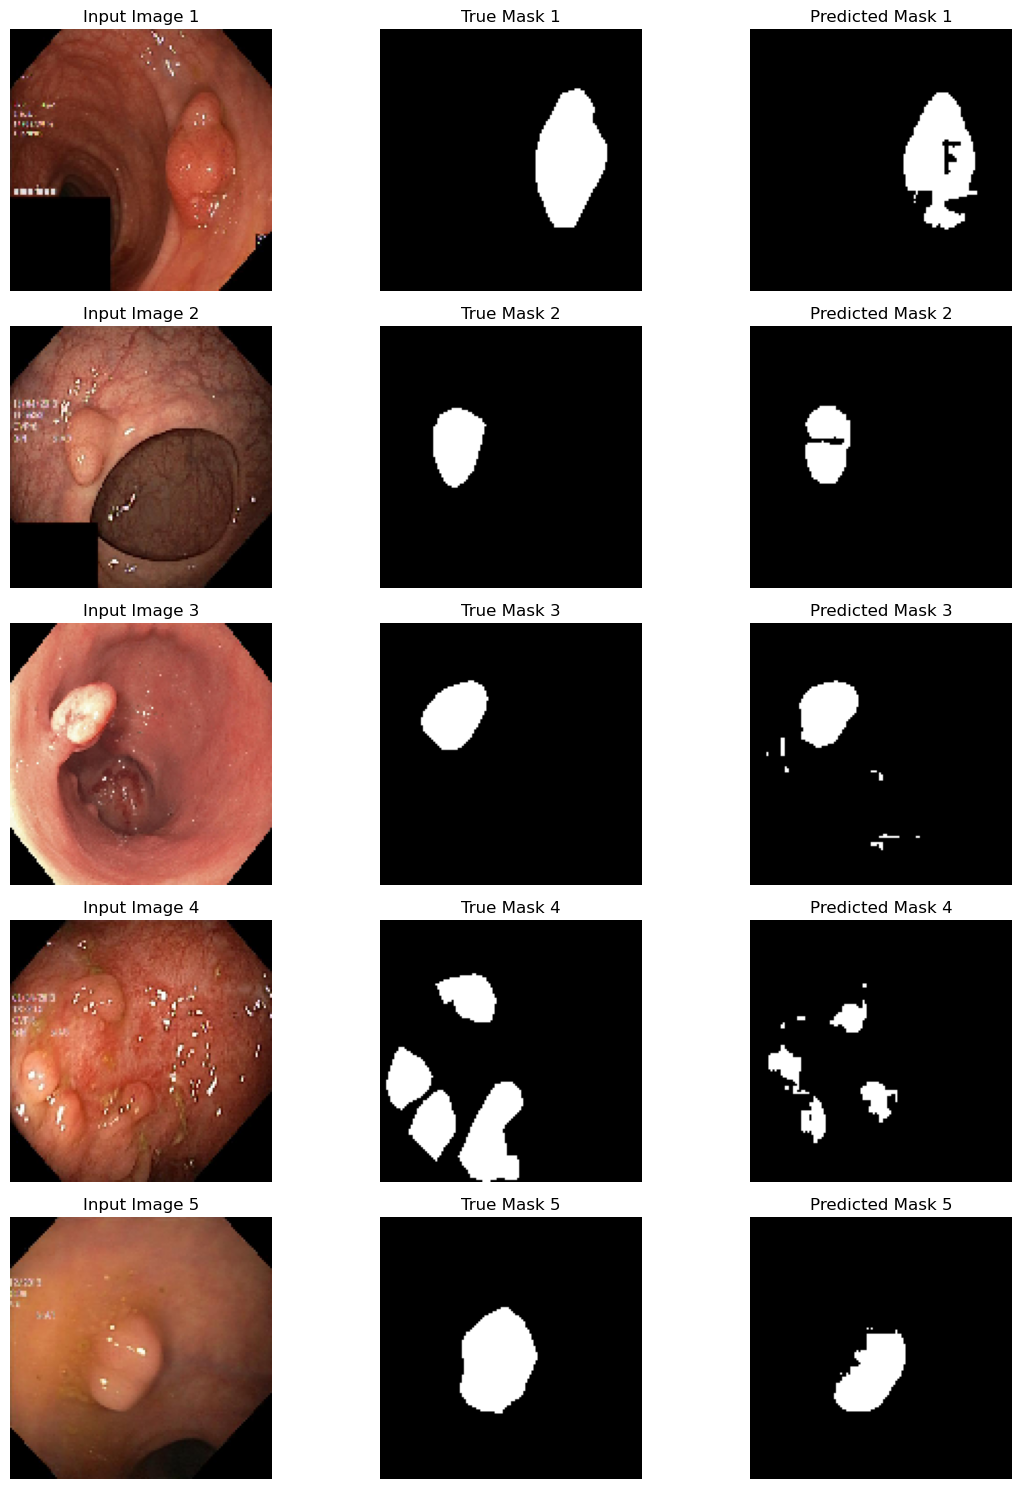

In [9]:
# --------- Plot Sample Predictions ---------
import random

# Select random samples from validation set
num_samples = 5  # number of examples to display
indices = random.sample(range(len(x_val)), num_samples)
sample_images = x_val[indices]
sample_true_masks = y_val[indices]

# Predict masks
pred_masks = model.predict(sample_images)

# Threshold predictions if binary class
if NUM_CLASSES == 1:
    pred_masks = (pred_masks > 0.5).astype(np.float32)

plt.figure(figsize=(12, num_samples * 3))

for i in range(num_samples):
    # Input image
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Input Image {i+1}")
    plt.axis('off')

    # True mask
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(sample_true_masks[i].squeeze(), cmap='gray')
    plt.title(f"True Mask {i+1}")
    plt.axis('off')

    # Predicted mask
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(pred_masks[i].squeeze(), cmap='gray')
    plt.title(f"Predicted Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()
